#4

In [1]:
!pip install torch

In [2]:
import torch
import torch.nn.functional as F

torch.manual_seed(42)
height, width, channel = 4, 4, 3
num_kernels = 4

input = torch.stack([
    torch.linspace(0, 1, height*width),
    torch.linspace(1, 0, height*width),
    torch.linspace(0, 0, height*width),
]).view(channel, height, width)

kernels = torch.stack([
    torch.linspace(0, 1, num_kernels),
    torch.linspace(1, 0, num_kernels),
    torch.linspace(0, 0, num_kernels),
], dim=1).view(num_kernels, channel, 1, 1)

(a)

1

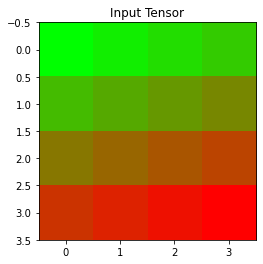

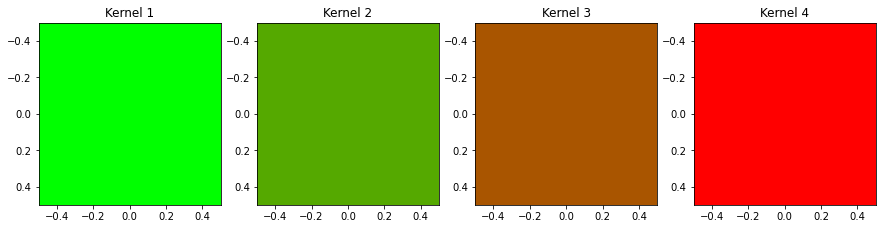

In [3]:
import matplotlib.pyplot as plt

input_tensor_for_plot = input.permute(1, 2, 0).numpy()

plt.imshow(input_tensor_for_plot)
plt.title('Input Tensor')
plt.show()

# Visualize each filter in the kernels tensor
fig, axes = plt.subplots(1, num_kernels, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    # Extract the kernel
    kernel = kernels[i]
    # Reorder the dimensions of the kernel for plotting
    kernel_for_plot = kernel.permute(1, 2, 0).numpy()
    # Display the kernel
    ax.imshow(kernel_for_plot, interpolation='none')
    ax.set_title(f'Kernel {i+1}')

plt.show()

2

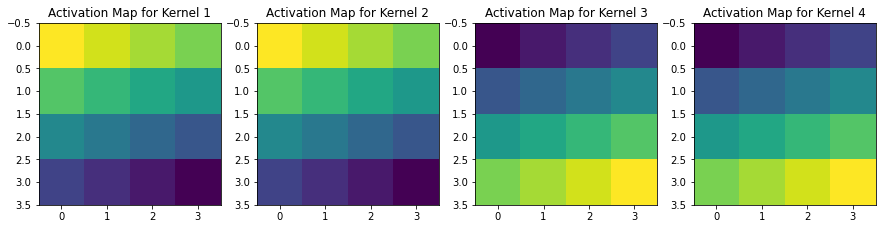

In [4]:
# Perform convolution using conv2d
output = F.conv2d(input.unsqueeze(0), kernels)

# Visualize the activation maps for each kernel as subplots
fig, axs = plt.subplots(1, num_kernels, figsize=(15, 5))
for i in range(num_kernels):
    activation_map = output[0, i:i+1, :, :].detach().numpy()  # Extract the activation map for a single kernel
    axs[i].imshow(activation_map[0])  # Convert to a numpy array and plot
    axs[i].set_title(f'Activation Map for Kernel {i+1}')

plt.show()

Based on these visualizations, the similarity rule that is likely being violated is the second one, which states that the similarity between an object and itself is the maximum similarity possible. In convolution there is no guarantee that the convolution of a vector with itself will give the maximum possible value. For the Maximum similarity rule, we expect that when the kernel is exactly the same as some part of the input tensor, it should produce the maximum convolutional response value. But in these visualizations, the similarity between kernel 2 and input pixel (2,2); 3 and input pixel (3,3) do not produce the maximum convolutional response value.

3

1. **Boundedness**: The cosine of any angle \\( \theta \\) is bounded between -1 and 1. Hence, \\( -1 \leq \text{CosSim}(x, y) \leq 1 \\), and so it is bounded by \\( b = 1 \\).

2. **Maximum similarity**: For any vector \\( x \\), the angle \\( \theta(x, x) \\) is 0, because the angle between a vector and itself is zero. Hence, \\( \text{CosSim}(x, x) = \cos(0) = 1 \\), which is the maximum value the cosine function can take.

3. **Distinct vectors**: If \\( x \neq y \\), then generally \\( \theta(x, y) \\) will be greater than 0. Thus, \\( \text{CosSim}(x, y) = \cos(\theta(x, y)) < 1 \\), unless \\( x \\) and \\( y \\) are parallel, in which case they are not distinct as they differ only by a scalar multiple.

4. **Symmetry**: The angle between \\( x \\) and \\( y \\) is the same as the angle between \\( y \\) and \\( x \\), hence \\( \theta(x, y) = \theta(y, x) \\), which implies \\( \text{CosSim}(x, y) = \text{CosSim}(y, x) \\).

Since cosine similarity meets all four conditions, we can conclude that it is indeed a similarity metric.


4

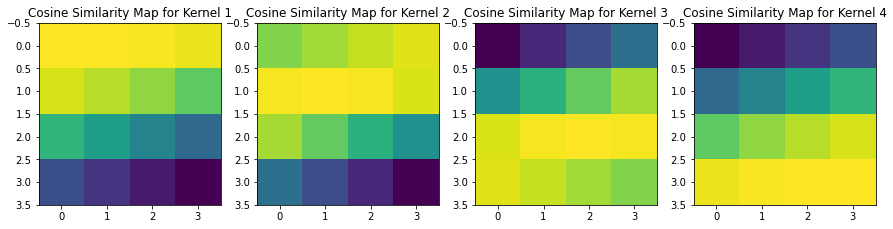

In [5]:
# Normalize input tensor and kernels
input_norm = F.normalize(input, p=2, dim=0)
kernels_norm = F.normalize(kernels.view(num_kernels, -1), p=2, dim=0).view_as(kernels)

# Perform convolution on normalized tensors
output_cosine = F.conv2d(input_norm.unsqueeze(0), kernels_norm)

# Visualize activation maps for each kernel
fig, axs = plt.subplots(1, num_kernels, figsize=(15, 5))
for i in range(num_kernels):
    activation_map_cosine = output_cosine[0, i, :, :].detach().numpy()
    axs[i].imshow(activation_map_cosine)
    axs[i].set_title(f'Cosine Similarity Map for Kernel {i+1}')

plt.show()

The activation maps reflect a similarity function because: 1. The similarity measure is bounded, which in the case of cosine similarity, it is bounded by 1; 2. The maximum similarity between an object and itself should be 1. After normalization, if the input and kernel are the same, the cosine similarity should be at its maximum; 3. The similarity between two distinct objects is not the maximum similarity. Since the maps are based on normalized values, only perfectly aligned (in orientation) inputs and kernels will have a maximum similarity; 4. The similarity measure should be symmetric, which is inherently satisfied by cosine similarity as the cosine of the angle between two vectors is independent of their order.

The difference:

Normal Convolution: In a standard convolution operation, \\( \mathbf{x}^T \mathbf{y} \\), the dot product between the input \\( \mathbf{x} \\) and the kernel \\( \mathbf{y} \\), the result is influenced by both the magnitude and direction of the vectors. The output reflects how much the input resembles the kernel in both magnitude and orientation. Larger magnitudes in either the input or the kernel will result in larger output values.

Normalized Convolution (Cosine Similarity): By normalizing both the input and the kernels, the implemented convolution operation now represents the cosine of the angle between the input and the kernel. Since \\( \mathbf{x}^T \mathbf{y} = \|\mathbf{x}\|_2 \|\mathbf{y}\|_2 \cos(\theta(\mathbf{x}, \mathbf{y})) \\), after normalization, the magnitudes \\( \|\mathbf{x}\|_2 \\) and \\( \|\mathbf{y}\|_2 \\) are equal to 1, so the dot product effectively becomes \\( \cos(\theta(\mathbf{x}, \mathbf{y})) \\). This means that the output is now solely dependent on the angle between the input and the kernel vectors, making it a measure of directional similarity rather than a combination of magnitude and direction.

(b)

1

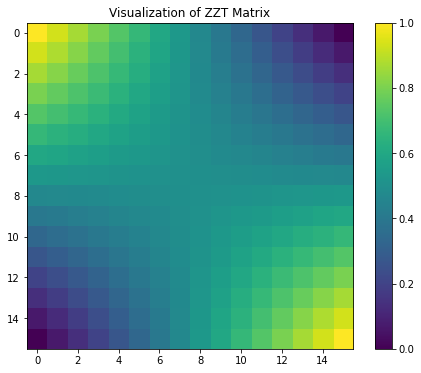

In [6]:
# Flatten and transpose the input tensor
flattened_input = input.view(channel, -1).transpose(0, 1)  # Shape: (hin * win, din)

# Compute ZZT
zzt_matrix = torch.matmul(flattened_input, flattened_input.transpose(0, 1))

# Visualize ZZT matrix
plt.figure(figsize=(8, 6))
plt.imshow(zzt_matrix.numpy())
plt.title('Visualization of ZZT Matrix')
plt.colorbar()
plt.show()

The visualization of the \\( \mathbf{Z}\mathbf{Z}^T \\) matrix indeed shows that only the corner diagonal entries are the brightest, which indicates that they have the maximum values. If the \\( \mathbf{Z}\mathbf{Z}^T \\) matrix is meant to represent the similarity of vectors, according to a similarity function, we would expect each entry on the diagonal to be the brightest in its respective row and column because this represents the similarity of a vector with itself (which should be the maximum). However, this is not the case as only the corners exhibit the brightest intensity.

This observation suggests that not all vectors in the matrix \\( \mathbf{Z} \\) have the maximum similarity with themselves, which violates the second rule for similarity functions: "The similarity between an object and itself is the maximum similarity possible." 

2

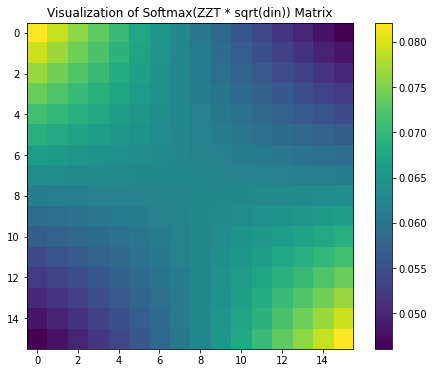

In [7]:
# Compute softmax of ZZT scaled by sqrt(din)
scaled_softmax = F.softmax(zzt_matrix / (flattened_input.shape[1] ** 0.5), dim=1)

# Visualize scaled softmax matrix
plt.figure(figsize=(8, 6))
plt.imshow(scaled_softmax.numpy())
plt.title('Visualization of Softmax(ZZT * sqrt(din)) Matrix')
plt.colorbar()
plt.show()

The visualization of the \\( \mathbf{Z}\mathbf{Z}^T \\) matrix indeed shows that only the corner diagonal entries are the brightest, which indicates that they have the maximum values. If the \\( \mathbf{Z}\mathbf{Z}^T \\) matrix is meant to represent the similarity of vectors, according to a similarity function, we would expect each entry on the diagonal to be the brightest in its respective row and column because this represents the similarity of a vector with itself (which should be the maximum). However, this is not the case as only the corners exhibit the brightest intensity.

This observation suggests that not all vectors in the matrix \\( \mathbf{Z} \\) have the maximum similarity with themselves, which violates the second rule for similarity functions: "The similarity between an object and itself is the maximum similarity possible." 

3

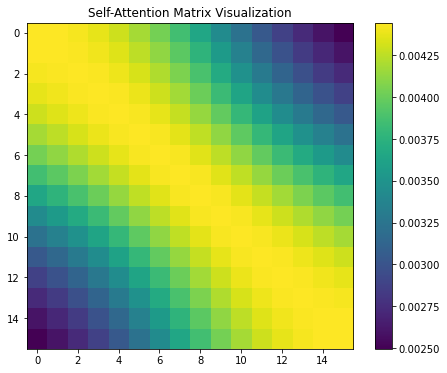

In [8]:
# Create the diagonal matrix Z_hat with 1/norms on the diagonal
Z_hat = torch.diag(1.0 / flattened_input.norm(p=2, dim=1))  # Adding a small value to prevent division by zero

# # Compute the dot product self-attention score matrix ZZ'
self_attention_scores = torch.matmul(flattened_input, flattened_input.transpose(0, 1))

# Compute the scaled self-attention scores matrix again
scaled_attention_scores = torch.matmul(torch.matmul(Z_hat, self_attention_scores), Z_hat)

# Flatten the scaled self-attention scores to apply softmax over the entire set of values
flattened_scaled_scores_for_softmax = scaled_attention_scores.view(-1)

# Apply softmax over the flattened scaled self-attention scores
softmax_scaled_scores = F.softmax(flattened_scaled_scores_for_softmax / torch.sqrt(torch.tensor(3, dtype=torch.float32)), dim=0)

# Reshape back to the original matrix shape (height*width, height*width)
attention_matrix = softmax_scaled_scores.view(height * width, height * width)

# Visualize the attention matrix using imshow
plt.figure(figsize=(8, 6))
plt.imshow(attention_matrix.numpy(), cmap='viridis')
plt.colorbar()
plt.title('Self-Attention Matrix Visualization')
plt.show()

The entries in this matrix could be produced by a similarity function because:

Boundedness: Similarity functions are bounded above by some value b. In the case of softmax applied to scaled self-attention scores, the output values are bounded between 0 and 1, satisfying this condition.

Maximum Similarity with Self: The similarity between an object and itself should be the maximum similarity possible. In the visualization, we would expect to see the brightest spots (indicating higher values) along the diagonal, representing each vector's self-similarity. The application of softmax ensures that the diagonal entries, which are scaled dot products of vectors with themselves, are emphasized compared to off-diagonal entries.

Distinctness: The similarity between two distinct objects should not be the maximum similarity. From the visualization, we can see variations in color intensity, suggesting that different vectors have varying degrees of similarity.

Symmetry: The similarity function should be symmetric. The self-attention matrix is symmetric around the diagonal, as the self-attention score between two vectors is the same regardless of their order.

4

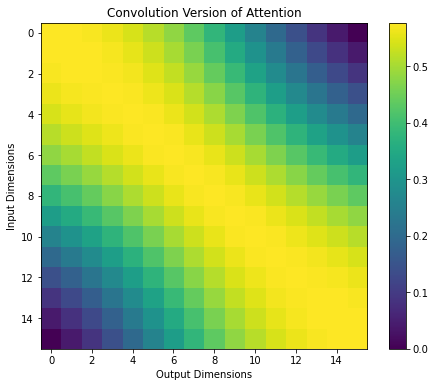

In [9]:
# Normalize the kernels derived from the input data
kernels_normalized = F.normalize(input.unsqueeze(0).view(3, 16).transpose(0, 1).view(-1, 3, 1, 1), dim=1)

# Normalize the input data
input_data_normalized = F.normalize(input.unsqueeze(0), dim=1)

# Perform convolution
convolution_result = F.conv2d(input_data_normalized, kernels_normalized)

# Normalize the output
convolution_result_normalized = convolution_result / torch.sqrt(torch.tensor(channel).float())

# Reshape the result for visualization
convolution_result_reshaped = convolution_result_normalized.reshape(height * width, height * width)

# Visualize the resulting matrix
plt.figure(figsize=(8, 6))
plt.imshow(convolution_result_reshaped.detach().numpy(), cmap='viridis')
plt.title('Convolution Version of Attention')
plt.xlabel('Output Dimensions')
plt.ylabel('Input Dimensions')
plt.colorbar()
plt.show()

In [12]:
kernels_normalized.size(0)

16

To make the dimensions match for the convolution operation described, you will need 16 convolutional kernels. This is calculated based on the reshaping and normalization of the input data into kernels, resulting in one kernel per input location (given the height and width of 4x4, thus 16 positions). Each of these 16 kernels is used in the convolution operation to create the attention-like mechanism.